## Sierra Leone AID funding and HDI performance  - Analysis with Time Series Regression in Python

In [32]:
#import required packages
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import numpy as np
import seaborn as sns
from matplotlib import pyplot as pl
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Aim and Hypothesis

* By comparing aid project funding for Sierra Leone between 1992 and 2014, and that country's rankings on HDI indicators for the same time period, I wanted to see if I could discover any relationships between these two sets off data from a time-series and causation point of view. 

* I think this could be an interesting analysis because: (in order of what I consider most likely to least likely), it could indicate that AID funding has an immediate positive effect, or it could indicate AID funding has a delayed positive effiect, or it could indicate AID funding has no clear effect, or it could indicate the AID funding has a negative 
effect, on a country's performance on HDI indicators over time. If this analysis was on a larger scale and more rigorous, this could provide insight to AID organisations about what sectors to focus on, and when to expect to see results from their AID funding based on historical data

- Null hypothesis: There is no relationship between amount spent on projects by year, per sector, and the countries performance on related HDI indicators
- Alternative hypothesis: There is some relationship between amount spent on projects by year, and sector, and the relevant countries performance on related HDI indicators

## Orginal Data

In [2]:
df = pd.read_csv("projects_original.csv")
df.head(1)

,project_id,is_geocoded,project_title,start_actual_isodate,start_actual_type,end_actual_isodate,end_actual_type,donors,donors_iso3,recipients,recipients_iso3,ad_sector_codes,ad_sector_names,ad_purpose_codes,ad_purpose_names,status,transactions_start_year,transactions_end_year,total_commitments,total_disbursements
0,SL/000021,1,Strengthening District Health Services Project,2005-10-17,start-actual,2013-12-31,end-actual,African Development Bank (AfDB),DAC,Sierra Leone,SLE,120,Health,12005,"Health, purpose unspecified",Completion,2005,2013,36149108.0,36149108.0


The modified projects dataset shows the total amount of disbursements on projects in four given sectors, in a given year between 1992 and 2014 inclusive.


In [3]:
df = pd.read_csv("projects.csv")
df.tail()

,Year,Agriculture,Government,Education,Health
18,2010,33775359.63,8.938357e+07,4.279596e+07,1.166506e+08
19,2011,34422890.91,1.071723e+08,2.010357e+07,8.670825e+07
20,2012,21758454.25,9.491549e+07,1.829507e+07,8.799426e+07
21,2013,24639726.58,6.898182e+07,1.635936e+07,8.315626e+07
22,2014,18018191.89,4.986670e+07,9.451358e+06,5.183863e+07


In [4]:
hdi_df_o = pd.read_csv('hdi.csv')
hdi_df_o.head()

,Year,Education Index,Agri Employment,Income Index,Life Expectancy Index
0,1992,0.194,64.1,0.382,0.250
1,1993,0.203,64.8,0.391,0.244
2,1994,0.213,65.5,0.386,0.242
3,1995,0.223,66.3,0.381,0.242
4,1996,0.232,66.3,0.342,0.246


## Data Load

Aid project disbursements in Sierra Leone by sector

In [5]:
#read in the project data. 
#As discussed in other parts, this data represents the sum of 
#disbursed funding for sectors of projects over that time period
df = pd.read_csv("projects.csv")

#import HDI dataset and show last 5 rows
hdi_df = pd.read_csv('hdi.csv')
hdi_df = hdi_df[hdi_df['Year'] <2015]

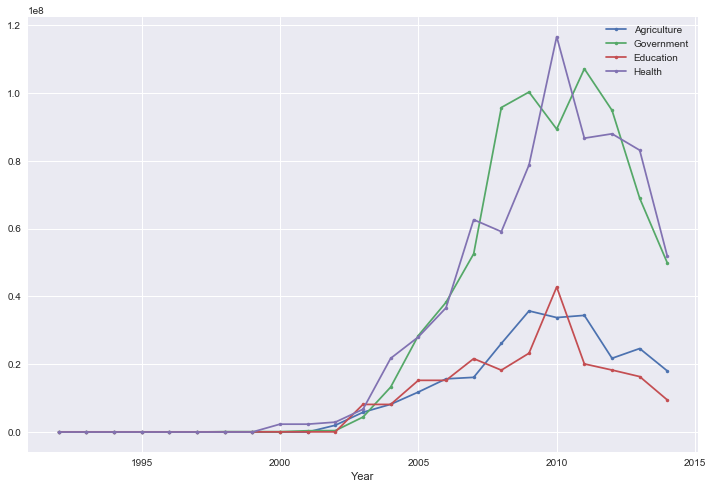

In [34]:
#plot the funding over time, y axis is 100 millions of USD
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
df.set_index('Year').plot(ax=ax, marker=".", linestyle="-")

*Conclusions*
* Goverment and Health attract the lion share of AID funding
* Education and Agriculture attract less, but a similar amount to each other
* Funding did not kick in until 2003/2004, rose until around 2010, then declined quickly after that

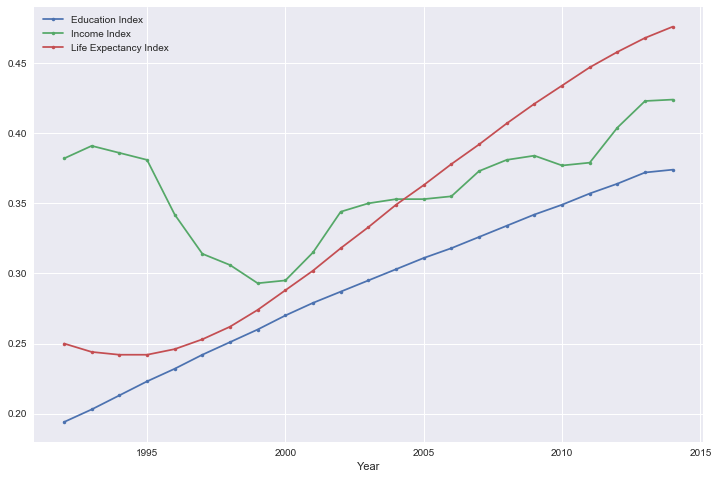

In [7]:
#plot the HDI over time
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
hdi_df.drop(columns=['Agri Employment']).set_index('Year').plot(ax=ax, marker=".", linestyle="-")

*Conclusions*
* Education and Life Expectancy Indexes rose steadily over time
* Income Index is more erratic, decling in the late 90s, but rising after that
* Agricultural Employment cannot be shown on the same graph as it's a different type of statistic

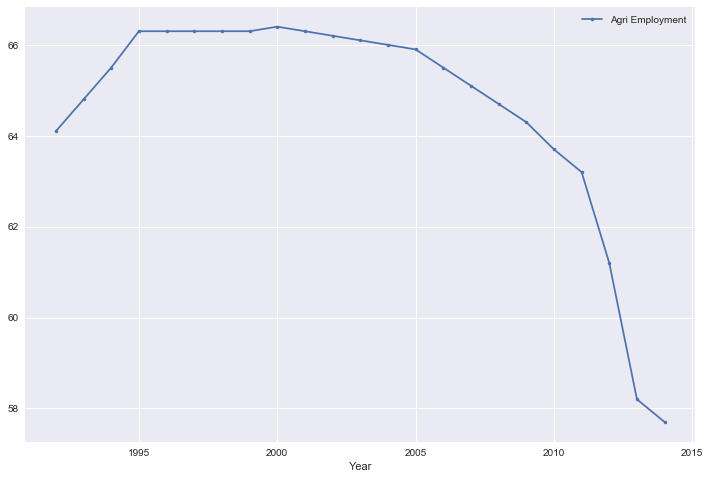

In [8]:
#plot the agricultural employment over time
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
hdi_df[['Year','Agri Employment']].set_index('Year').plot(ax=ax, marker=".", linestyle="-")

*Conclusions*
* There's a general downward trend in Agricultural Employment from 1992 to 2014
* The most rapid decline occurs between 2010 and 2015, just after AID funding for Agricultural projects peaked

In [9]:
#combine the datasets 
df_c = pd.merge(df, hdi_df, how='inner', on='Year')
df_c.head()

,Year,Agriculture,Government,Education,Health,Education Index,Agri Employment,Income Index,Life Expectancy Index
0,1992,0.0,0.0,51750.07143,0.0,0.194,64.1,0.382,0.250
1,1993,0.0,0.0,51750.07143,0.0,0.203,64.8,0.391,0.244
2,1994,0.0,0.0,51750.07143,0.0,0.213,65.5,0.386,0.242
3,1995,0.0,0.0,51750.07143,0.0,0.223,66.3,0.381,0.242
4,1996,0.0,0.0,51750.07143,0.0,0.232,66.3,0.342,0.246


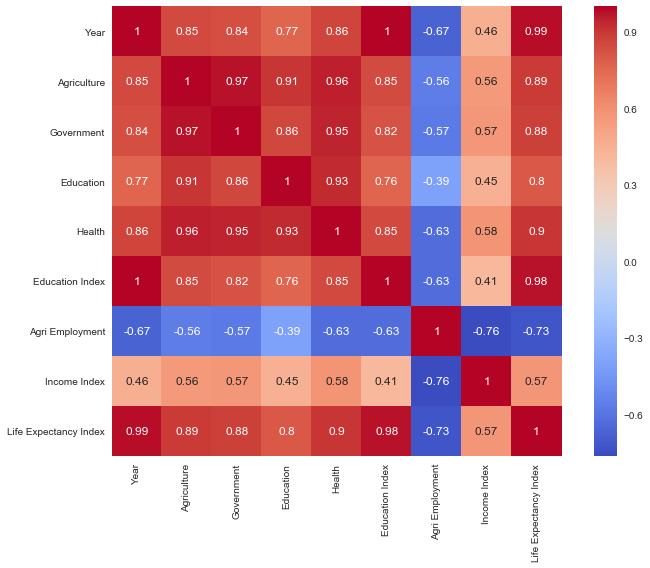

In [33]:
#produce a correlation heatmap between the variables
sns.heatmap(df_c.corr(),cmap="coolwarm", annot=True, square=True)

The correlations we are most interested in are:
* Education Index with Education = 0.76, showing a positive relationship. Interestingly Health, Goverment and Agricultural spending are correlate more highly with Educational Index performance than Educational spending which I did not expect.

* Life Expectancy Index with Health = 0.9, showing a positive relationship. Health spending has the highest correlation with the Index amongst the categories of spending which is what I expected.

* Income Index with Goverment = 0.57, showing a weak positive relationship. I expected Goverment spending to have the most correlation amongst the categories of spending, however Health spending has a slightly higher correlation. 

* Agricultural Employment with Agriculture = -0.56, showing a moderate negative relationship. I expected Agricultural spending to have a high negative correlation with Agricultural employment. Health spending has a stronger relationship, indicative of the fund the funding sectors all follow similar patterns.

Lets look at Education

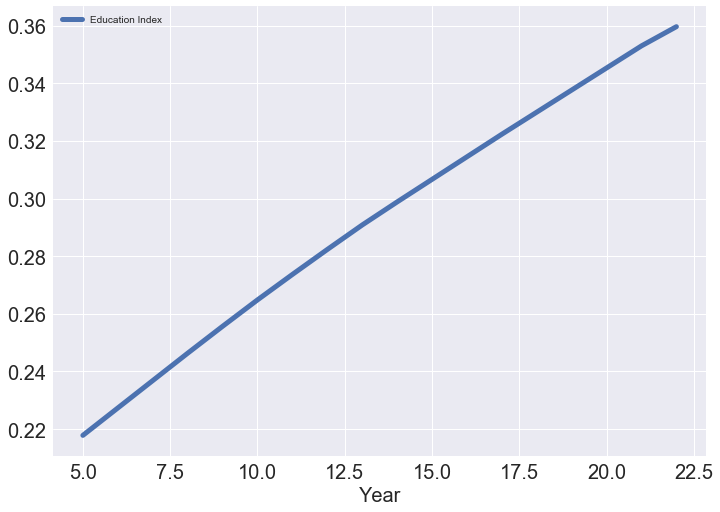

In [35]:
#smooth the data to see the long term trend
edu_i = df_c[['Education Index']]
edu_i.rolling(6).mean().plot(linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

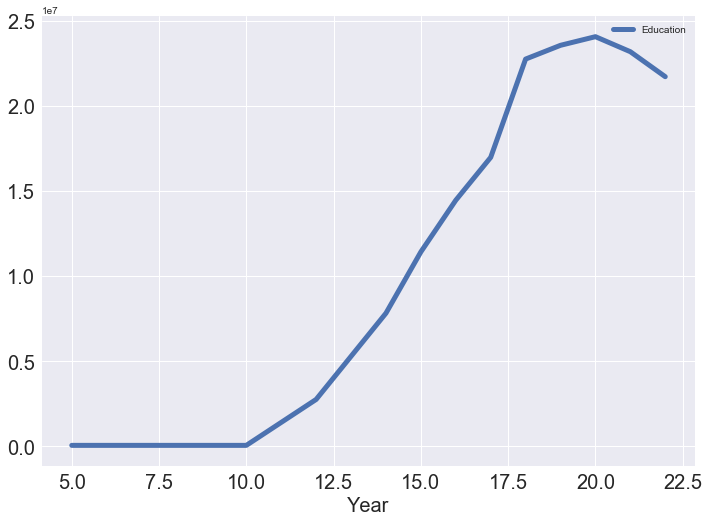

In [36]:
#smooth the data to see the long term trend
edu_f = df_c[['Education']]
edu_f.rolling(6).mean().plot(linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [13]:
#set up target and predictor columns
y = df_c[['Education Index']]
X = df_c[['Education']].astype('int64')

#set up an autocorrelation column for the target
X['Education Index Lag 1'] = y.shift(1)
#set up a lag 1 column for the predictor which should be have more predictive power than lag 0 values
X['Education Lag 1'] = X['Education'].shift(1)
#set up the intercept for the statsmodel regression
X['Intercept'] = 1

#drop the first row of data due to the autocorrelation
X = X.iloc[1:,:]

y = y.iloc[1:,:]

#add a trend column
X['trend'] = range(1,len(X.index)+1)

In [14]:
#fit the regression
fit_1 = sm.OLS(y, X).fit()

# Inspect the results
print(fit_1.summary())

                            OLS Regression Results                            
Dep. Variable:        Education Index   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.184e+04
Date:                Tue, 20 Nov 2018   Prob (F-statistic):           4.95e-29
Time:                        17:48:52   Log-Likelihood:                 120.90
No. Observations:                  22   AIC:                            -231.8
Df Residuals:                      17   BIC:                            -226.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Education              2.056e-

A P value of 0.171 suggests that if the null hypothesis were true (that Education Lag 1 funding has no effect on Education Index), we would expect this kind of result 17% of the time. This is not a statistically significant effect. 

In [15]:
#fit the model again, taking away the predictors we are not interested in 
fit_2 = sm.OLS(y, X.drop(['trend','Education','Education Index Lag 1'], axis = 1)).fit()

# Inspect the results
print(fit_2.summary())

                            OLS Regression Results                            
Dep. Variable:        Education Index   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     37.97
Date:                Tue, 20 Nov 2018   Prob (F-statistic):           5.09e-06
Time:                        17:48:52   Log-Likelihood:                 45.351
No. Observations:                  22   AIC:                            -86.70
Df Residuals:                      20   BIC:                            -84.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Education Lag 1  3.754e-09   6.09e-10     

Conclusion 
* Using Education funding from the previous year, to predict Education Index performance in the current year, the predictive power (R squared) is only 0.638, indicated that Education funding is not a strong predictor of Education Index performance

Lets look at Health

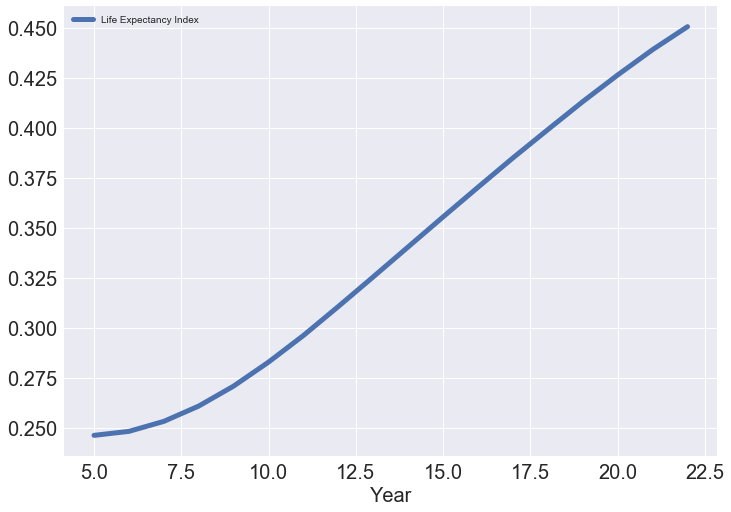

In [37]:
health_i = df_c[['Life Expectancy Index']]
health_i.rolling(6).mean().plot(linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

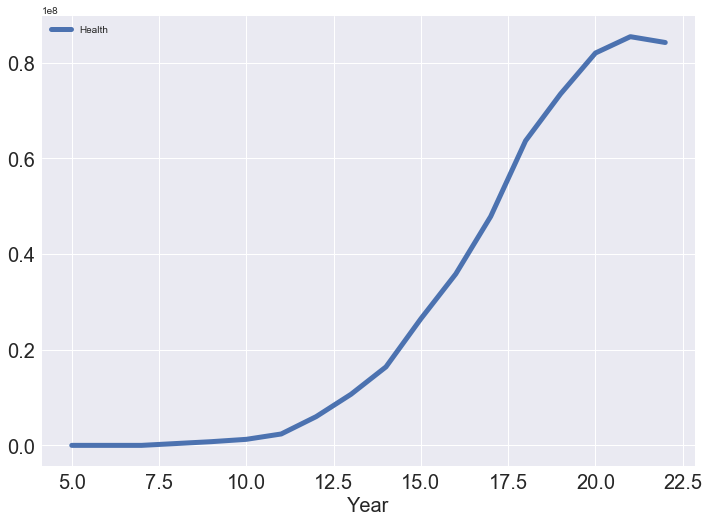

In [38]:
health_i = df_c[['Health']]
health_i.rolling(6).mean().plot(linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [18]:
y = df_c[['Life Expectancy Index']]
X = df_c[['Health']].astype('int64')

X['Life Expectancy Index Lag 1'] = y.shift(1)
X['Health Lag 1'] = X['Health'].shift(1)
X['Intercept'] = 1

X = X.iloc[1:,:]

y = y.iloc[1:,:]

# trend
X['trend'] = range(1,len(X.index)+1)

In [19]:
fit_1 = sm.OLS(y, X).fit()

# Inspect the results
print(fit_1.summary())

                              OLS Regression Results                             
Dep. Variable:     Life Expectancy Index   R-squared:                       0.999
Model:                               OLS   Adj. R-squared:                  0.999
Method:                    Least Squares   F-statistic:                     6347.
Date:                   Tue, 20 Nov 2018   Prob (F-statistic):           9.88e-27
Time:                           17:48:53   Log-Likelihood:                 104.49
No. Observations:                     22   AIC:                            -199.0
Df Residuals:                         17   BIC:                            -193.5
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

A P value of 0.029 suggests that if the null hypothesis were true (that Health Lag 1 funding has no effect on Education Index), we would expect this kind of result 2.9% of the time. As this is lower than the generally accepted level of statistical significance (5%), this is suggest there is enough evidence to reject the null hypothesis, and conclude that Health Lag 1 funding is a predictor of the Life Expectancy Index.

Another way to put it, is that if you drew a card from a shuffled deck, and someone guessed it correctly, it seems more likely there was some trick involved, rather than them guessing randomly

In [20]:
fit_2 = sm.OLS(y, X.drop(['trend','Health','Life Expectancy Index Lag 1'], axis = 1)).fit()

# Inspect the results
print(fit_2.summary())

                              OLS Regression Results                             
Dep. Variable:     Life Expectancy Index   R-squared:                       0.836
Model:                               OLS   Adj. R-squared:                  0.828
Method:                    Least Squares   F-statistic:                     102.1
Date:                   Tue, 20 Nov 2018   Prob (F-statistic):           2.66e-09
Time:                           17:48:53   Log-Likelihood:                 43.982
No. Observations:                     22   AIC:                            -83.96
Df Residuals:                         20   BIC:                            -81.78
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Health Lag 1  1.96

Conclusion 
* Using Health spending from the previous year, to predict Life Expectancy Index performance in the current year, the predicted power (R squared) is 0.828, indicating that Health spending is a reasonably strong predictor of Life Expectancy Index performance

Let's look at Agriculture

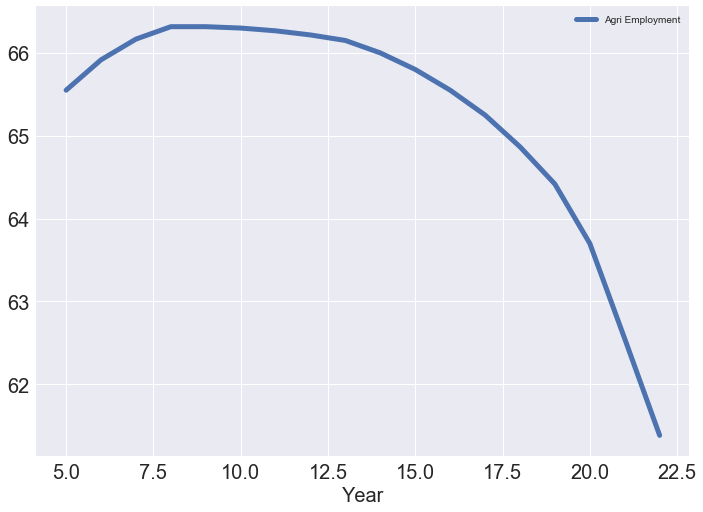

In [40]:
agri_e = df_c[['Agri Employment']]
agri_e.rolling(6).mean().plot(linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

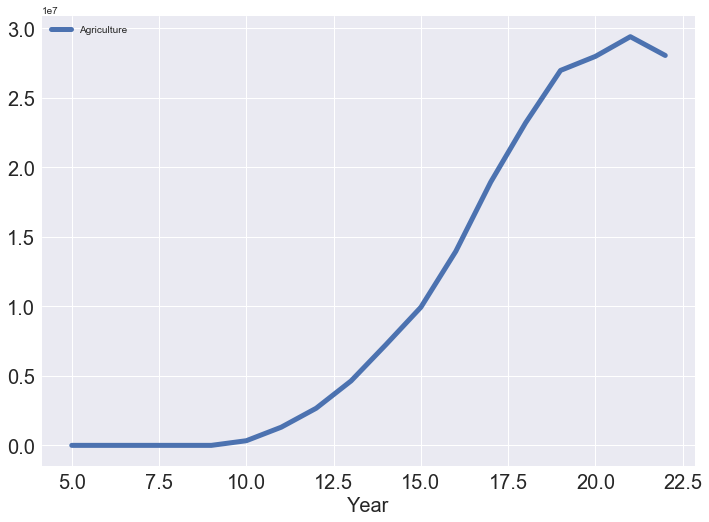

In [42]:
agri_f = df_c[['Agriculture']]
agri_f.rolling(6).mean().plot(linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [23]:
y = df_c[['Agri Employment']]
X = df_c[['Agriculture']].astype('int64')

X['Agri Employment Lag 1'] = y.shift(1)
X['Agriculture Lag 1'] = X['Agriculture'].shift(1)
X['Intercept'] = 1

X = X.iloc[1:,:]

y = y.iloc[1:,:]

# trend
X['trend'] = range(1,len(X.index)+1)


In [24]:
fit_1 = sm.OLS(y, X).fit()

# Inspect the results
print(fit_1.summary())

                            OLS Regression Results                            
Dep. Variable:        Agri Employment   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     96.65
Date:                Tue, 20 Nov 2018   Prob (F-statistic):           1.86e-11
Time:                        17:48:54   Log-Likelihood:                -16.244
No. Observations:                  22   AIC:                             42.49
Df Residuals:                      17   BIC:                             47.94
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Agriculture             2.85e-

A P value of 0.639 suggests that if the null hypothesis were true (that Agricultural Funding Lag 1 funding has no effect on Agri Employment), we would expect this kind of result 63.9% of the time. This is not a statistically significant effect. 

In [25]:
fit_2 = sm.OLS(y, X.drop(['trend','Agriculture','Agri Employment Lag 1'], axis = 1)).fit()

# Inspect the results
print(fit_2.summary())

                            OLS Regression Results                            
Dep. Variable:        Agri Employment   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     19.01
Date:                Tue, 20 Nov 2018   Prob (F-statistic):           0.000303
Time:                        17:48:54   Log-Likelihood:                -43.734
No. Observations:                  22   AIC:                             91.47
Df Residuals:                      20   BIC:                             93.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Agriculture Lag 1  -1.35e-07    3.1e-0

Conclusion 
* Using Agricultural funding from the previous year, to predict Agricultural Employment in the current year, the predictive power (R squared) is only 0.462, indicating that Agricultural funding is not a strong predictor of Agricultural Employment.

Lets look at Income

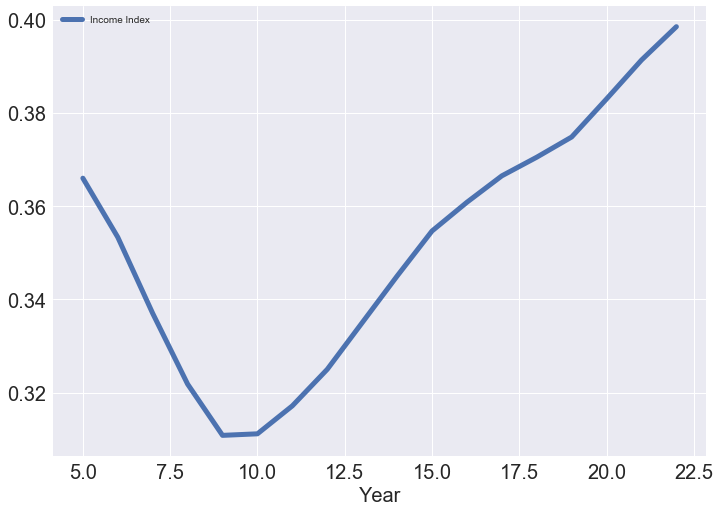

In [43]:
income_i = df_c[['Income Index']]
income_i.rolling(6).mean().plot(linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

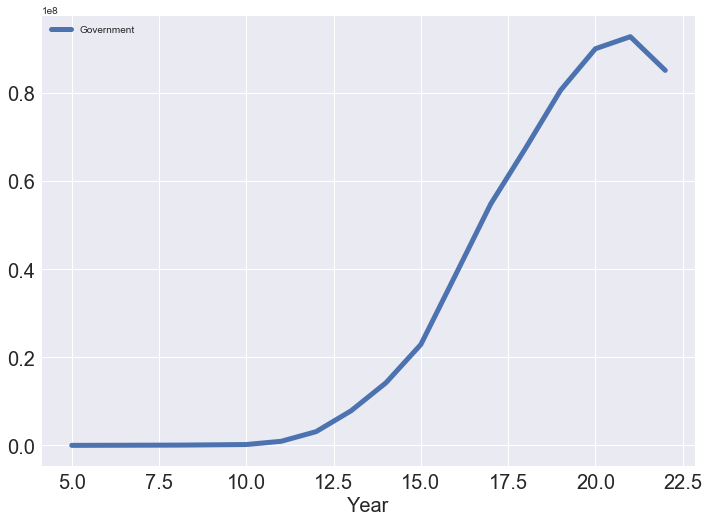

In [44]:
government_f = df_c[['Government']]
government_f.rolling(6).mean().plot(linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [28]:
y = df_c[['Income Index']]
X = df_c[['Government']].astype('int64')

X['Income Index Lag 1'] = y.shift(1)
X['Government Lag 1'] = X['Government'].shift(1)
X['Intercept'] = 1

X = X.iloc[1:,:]

y = y.iloc[1:,:]

# trend
X['trend'] = range(1,len(X.index)+1)

In [29]:
fit_1 = sm.OLS(y, X).fit()

# Inspect the results
print(fit_1.summary())

                            OLS Regression Results                            
Dep. Variable:           Income Index   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     28.83
Date:                Tue, 20 Nov 2018   Prob (F-statistic):           2.24e-07
Time:                        17:48:55   Log-Likelihood:                 63.752
No. Observations:                  22   AIC:                            -117.5
Df Residuals:                      17   BIC:                            -112.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Government         -4.485e-11   2.48

A P value of 0.951 suggests that if the null hypothesis were true (that Agricultural Funding Lag 1 funding has no effect on Agri Employment), we would expect this kind of result 95.1% of the time. This is not a statistically significant effect. 

In [30]:
fit_2 = sm.OLS(y, X.drop(['trend','Government','Income Index Lag 1'], axis = 1)).fit()

# Inspect the results
print(fit_2.summary())

                            OLS Regression Results                            
Dep. Variable:           Income Index   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     16.01
Date:                Tue, 20 Nov 2018   Prob (F-statistic):           0.000701
Time:                        17:48:55   Log-Likelihood:                 47.649
No. Observations:                  22   AIC:                            -91.30
Df Residuals:                      20   BIC:                            -89.12
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Government Lag 1  6.156e-10   1.54e-10  

Conclusion 
* Using Goverment funding from the previous year, to predict Income Index performance in the current year, the predictive power (R squared) is only 0.417, indicating that Goverment funding is not a strong predictor of Income Index performance

## Final Conclusions

* Both project funding and HDI performance seem to rise over the same time period, and though there are some strong correlations, there are many confounding variables not accounted for. 
* Only Health funding (Lag 1 year) seems to have a statistically significant relationship with a relevant HDI indicator
* What funding should be prioritised for Sierra Leone? Due to some of the problems mentioned below, this analysis would not be sufficient for AID decision making



## Problems/Risks
* The lack of project funding in the early 90s may skew the regression
* The AID dataset may only represent a small part of foreign aid to Sierra Leone and thus will not demonstrate any causal effects on the higher level indicators.
* There may be a significant time lag between the project funding and the HDI effect, whereas I have only accounted for 1 year lag.
* That there are better performance indicators than the HDI ones I've chosen to demonstrate relationships with project funding.
* That there are not enough data points/years for time series to be a valid method of analysis.
* There are confounders such as global growth and technology which could explain why both the funding and metrics were improving, regardless of their relationship with each other. 

## Success Metrics

* If my conclusions logically follow from my analysis, and accurately describe whether I was able to find any meaningful relationships and if there is any further analysis that may be required

* If I'm unable to determine any significant relationships, the project can still be considered a success as I applied data science skills to a problem I was interested in, and gained practice with data manipulation and Python programming.